In [1]:
## DATASET

import os
import numpy as np
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, img_path, perms, list_IDs):
        'Initialization'
        self.img_path = img_path
        self.perms = perms
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Get one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img = np.fromfile(os.path.join(self.img_path, f'{ID:06d}.raw'), np.uint8).reshape(200, 200, 200)
        img = np.expand_dims(img, axis=0)
        perm = np.log(self.perms[index] / 9.869233e-16)
        perm = np.expand_dims(perm, axis=-1)

        return img, perm

In [2]:
## MODEL

import torch
import torch.nn as nn


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool3d(kernel_size=2, stride=2)]
        else:
            conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv3d, nn.BatchNorm3d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv3d, nn.ReLU(inplace=True)]
            in_channels = v
    layers += [nn.AdaptiveAvgPool3d((1, 1, 1))]
    return nn.Sequential(*layers)


class VGG3D(nn.Module):

    def __init__(self, features, init_weights=False):
        super(VGG3D, self).__init__()
        self.features = features
        self.regressor = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(128, 1),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


True
using cuda
(3, 2000)
Let's use 2 GPUs!


Epoch 0: 0it [00:00, ?it/s]c:\Users\drp\anaconda3\envs\Hello\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
Epoch 0: 300it [05:59,  1.20s/it]


epoch: 0 | training loss: 0.2543 | validation loss: 0.0540 | R2: 0.4943


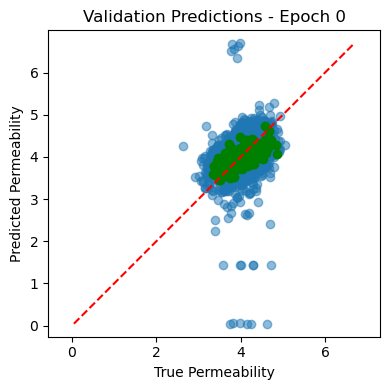

Epoch 1: 0it [00:00, ?it/s]c:\Users\drp\anaconda3\envs\Hello\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
Epoch 1: 300it [06:32,  1.31s/it]


epoch: 1 | training loss: 0.1046 | validation loss: 0.0647 | R2: 0.3793


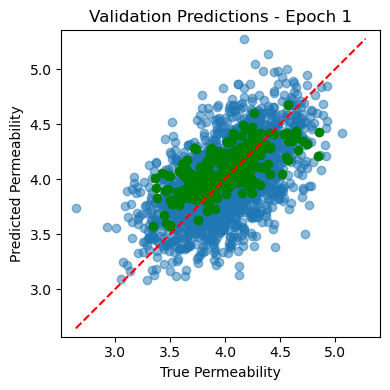

Epoch 2: 0it [00:00, ?it/s]c:\Users\drp\anaconda3\envs\Hello\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
Epoch 2: 300it [05:58,  1.19s/it]


epoch: 2 | training loss: 0.1115 | validation loss: 0.0677 | R2: 0.3591


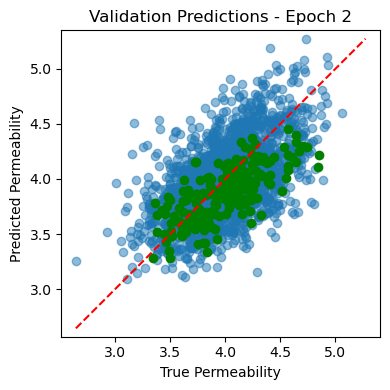

Epoch 3: 0it [00:00, ?it/s]c:\Users\drp\anaconda3\envs\Hello\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
Epoch 3: 300it [05:57,  1.19s/it]


epoch: 3 | training loss: 0.0874 | validation loss: 0.0592 | R2: 0.4438


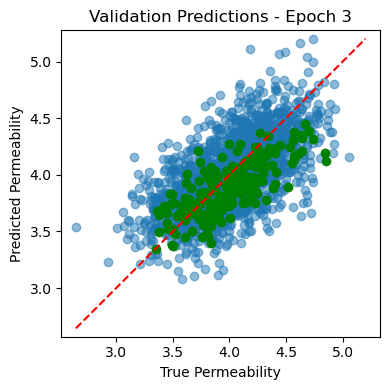

Epoch 4: 0it [00:00, ?it/s]c:\Users\drp\anaconda3\envs\Hello\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
Epoch 4: 300it [06:06,  1.22s/it]


epoch: 4 | training loss: 0.0859 | validation loss: 0.0714 | R2: 0.3061


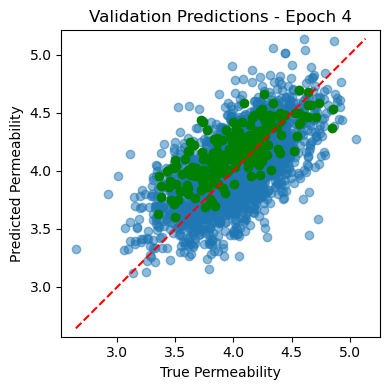

Epoch 5: 0it [00:00, ?it/s]c:\Users\drp\anaconda3\envs\Hello\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
Epoch 5: 151it [02:58,  1.15s/it]

In [ ]:
## TRAINING

import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)

rock_type = 'sandstone'
# hyper-parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print (f'using {device}')

n_channels = 1
n_epochs = 50
lr = 5e-3
batch_size = 6
num_samples = 2000


# dataloader
base_dir = r"E:\Oleg\Новая папка\PermNet"
data_dir = os.path.join(base_dir, 'data', 'subvols', rock_type)
data_path = os.path.join(base_dir, 'data', f'poro_perm_{rock_type}_normalized.npy')
true_data = np.load(data_path)[:, :num_samples]
print(true_data.shape)

IDs = true_data[0].astype(np.int32)
perms = true_data[2]
idx = perms > 1e-20
perms = perms[idx]
IDs = IDs[idx]

idx = np.random.permutation(len(IDs))
perms = perms[idx]
IDs = IDs[idx]

val_ratio = 0.1
val_num = int(len(idx) * val_ratio)
perms_train = perms[val_num:]
IDs_train = IDs[val_num:]

perms_val = perms[:val_num]
IDs_val = IDs[:val_num]

train_dataset = MyDataset(data_dir, perms_train, IDs_train)
valid_dataset = MyDataset(data_dir, perms_val, IDs_val)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# model
cfg = [8, 8, 'M', 16, 16, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256]
model = VGG3D(make_layers(cfg, batch_norm=True))
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)
model_dir = os.path.join(base_dir, 'saved_models', rock_type)
os.makedirs(model_dir, exist_ok=True)


# training
criterior = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_loss_history = np.zeros(n_epochs)
valid_loss_history = np.zeros(n_epochs)

for epoch in range(n_epochs):
    train_loss = 0

    all_true_train = []
    all_pred_train = []
    all_true_val = []
    all_pred_val = []

    for i, (img, true_perm) in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch}'):
        # plt.figure(figsize=(5,5))
        # plt.imshow(img[0, 0, 0])
        # plt.show
        img = img.to(device, dtype=torch.float)
        true_perm = true_perm.to(device, dtype=torch.float)
        optimizer.zero_grad()
        pred_perm = model(img)
        loss = criterior(pred_perm, true_perm)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        all_true_train.append(true_perm.detach().cpu().numpy().flatten())
        all_pred_train.append(pred_perm.detach().cpu().numpy().flatten())

        
    with torch.no_grad():
        valid_loss = 0
        for img, true_perm in valid_dataloader:
            img = img.to(device, dtype=torch.float)
            true_perm = true_perm.to(device, dtype=torch.float)
            pred_perm = model(img)
            loss = criterior(pred_perm, true_perm)
            valid_loss += loss.item()

            all_true_val.append(true_perm.detach().cpu().numpy().flatten())
            all_pred_val.append(pred_perm.detach().cpu().numpy().flatten())

    
    train_loss_history[epoch] = train_loss/len(train_dataloader)
    valid_loss_history[epoch] = valid_loss/len(valid_dataloader)

    print('epoch: {} | training loss: {:.4f} | validation loss: {:.4f} | R2: {:.4f}'.format(epoch, train_loss_history[epoch], valid_loss_history[epoch], r2_score(np.concatenate(all_true_val), np.concatenate(all_pred_val))))
    scheduler.step()
    
    torch.save(model.state_dict(), os.path.join(model_dir, 'model_%d.pth'%epoch))
    np.save(os.path.join(model_dir, 'train_loss_history.npy'), train_loss_history)
    np.save(os.path.join(model_dir, 'valid_loss_history.npy'), valid_loss_history)

    all_true_train = np.concatenate(all_true_train)
    all_pred_train = np.concatenate(all_pred_train)
    all_true_val = np.concatenate(all_true_val)
    all_pred_val = np.concatenate(all_pred_val)

    # Scatter plot of predictions vs. true
    plt.figure(figsize=(4, 4))
    plt.scatter(all_true_train, all_pred_train, alpha=0.5)
    plt.scatter(all_true_val, all_pred_val, color='g')
    min_val = min(np.min(all_true_train), np.min(all_pred_train))
    max_val = max(np.max(all_true_train), np.max(all_pred_train))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # y=x reference line
    plt.xlabel("True Permeability")
    plt.ylabel("Predicted Permeability")
    plt.title(f"Validation Predictions - Epoch {epoch}")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    plt.close()

print('done')

In [ ]:
## VALIDATION